In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np

from plottable import Table, ColumnDefinition
from plottable.formatters import decimal_to_percent
from plottable.plots import bar, percentile_bars, percentile_stars, progress_donut

# Main figures - benchmarking

In [282]:
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent, apply_formatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import cividis
import itertools

In [79]:
data = pd.read_csv('/home/dkriukov/ComputAge/tmp_bench_results/bench2_published_bench_bools.csv', 
                   index_col=0)
selection = pd.read_table('/home/dkriukov/ComputAge/tmp/DeAge Paper Meta - Selection.tsv', 
                          sep='\t', 
                          )
classcond = {
    "NDD": ['AD', 'PD', 'MS', 'DLB', 'CJD',],
    "CVD": ['HTN','AS','IHD','CVA','HF',],
    "ISD": ['CD','UC','IBD','IBS','SLE','HIV'],
    "MSD": ['SP','OP','OA','RA',],
    "MBD": ['OBS','IR','T1D','T2D','MBS',],
    "LVD": ['NAFLD','NASH','PBC','PSC','LF','HCC',],
    "LUD": ['COPD', 'IPF'],
    "PGS": ['WS', 'HGPS', 'CGL', 'DS']
}

def cond2class(conds: list):
    classes = []
    for c in conds:
        for cl, l in classcond.items():
            if c in l:
                classes.append(cl)
    return classes

conds = [c.split(':')[0] for c in data.columns]
classes = cond2class(conds)

In [299]:
df = pd.melt(data.reset_index(), id_vars=['index'])
df['Condition'] = [c.split(':')[0] for c in df['variable']]
df['Class'] = cond2class(df['Condition'])
df = df.drop(['variable', 'Condition'], axis=1)

sums = df.groupby(['index', 'Class']).sum()
counts = df.groupby(['index', 'Class']).count()
sums = pd.pivot(sums.reset_index(), index='index', columns=['Class'], values='value')
counts = pd.pivot(counts.reset_index(), index='index', columns=['Class'], values='value')
sums['Total'] = sums.sum(axis=1)
counts['Total'] = counts.sum(axis=1)
classcounts = counts.iloc[0]
vals = sums / counts
vals.index.name = 'Model'
vals = vals.sort_values('Total', ascending=False)

In [317]:
cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
)

def form(base):
    def formatter(x):
        return f'{str(int(round(x * base)))}/{base}'
    return formatter

col_defs = []
for col in vals.columns[:-1]:
    base = classcounts[col]
    cldef = ColumnDefinition(
                    col,
                    width=1.0,
                    plot_fn=bar,
                    textprops={"ha": "center"},
                    plot_kw={
                        "cmap": cmap,
                        "plot_bg_bar": True,
                        "annotate": True,
                        "height": 0.9,
                        "lw": 0.5,
                        "formatter": form(base) #apply_formatter()
                        },
                    )
    col_defs.append(cldef)

col_defs = col_defs + [
    ColumnDefinition(
                    'Total',
                    width=1.2,
                    plot_fn=bar,
                    border="left",
                    textprops={"ha": "center"},
                    plot_kw={
                        "cmap": cividis,
                        "plot_bg_bar": True,
                        "annotate": True,
                        "height": 0.9,
                        "lw": 0.5,
                        "formatter": form(classcounts['Total']) 
                        },
                    ),
        ColumnDefinition(
            name="Model",
            textprops={"ha": "right", "weight": "bold"},
            width=6.5,
        )
    ]

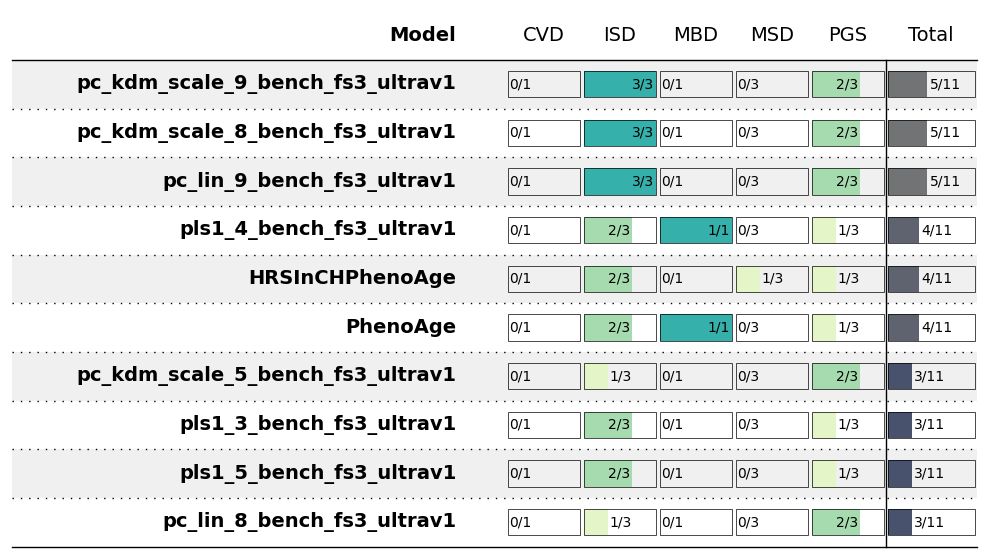

In [318]:
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"

fig, ax = plt.subplots(figsize=(12.5, 7))

table = Table(
    vals.head(10),
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    odd_row_color="#ffffff", 
    even_row_color="#f0f0f0",
    ax=ax,
    textprops={"fontsize": 14},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
)

# Supplementary figures

In [2]:
test = pd.read_csv('/home/dkriukov/ComputAge/tmp_bench_results/bench2_published_bench_adj_pvals.csv', index_col=0)

test.head(3)

,IBD:GSE32148:AAP,AS:GSE56581:AAP,IBD:GSE87640:AAP,HIV:GSE67751:AAP,RA:GSE131989:AAP,RA:GSE134429:AAP,OBS:GSE49909:AAP,OP:GSE99624:AAP,WS:GSE131752:AAP,HGPS:GSE182991:AAP,CGL:GSE214297:AAP
Horvathv1,0.454860,0.929344,0.454860,0.000158,0.479419,0.690786,0.862874,0.993061,0.175922,0.929344,0.001923
Hannum,0.687500,0.997572,0.074406,0.054521,0.450865,0.450865,0.997572,0.997572,0.450865,0.450865,0.074406
Lin,0.077629,0.949155,0.036278,0.000017,0.851966,0.642649,0.851966,0.851966,0.274047,0.851966,0.949155


In [3]:
#AAP
aap = test.filter(regex='AAP')


data = aap.copy()
data = data.where(data < 0.05)
data = -np.log10(data) 
total = np.isfinite(data).sum(1).sort_values(ascending=False)
sorted_indices = total.index
data = data[data.columns.sort_values()]
data['Total'] = total
data = data.loc[sorted_indices].iloc[:16]


groups = [s.split(':')[0] for s in data.columns[:-1]] #tmp, need to be changed with disease classes
group_colors = {g:c for g,c in zip(np.unique(groups), sns.color_palette('Set3'))}

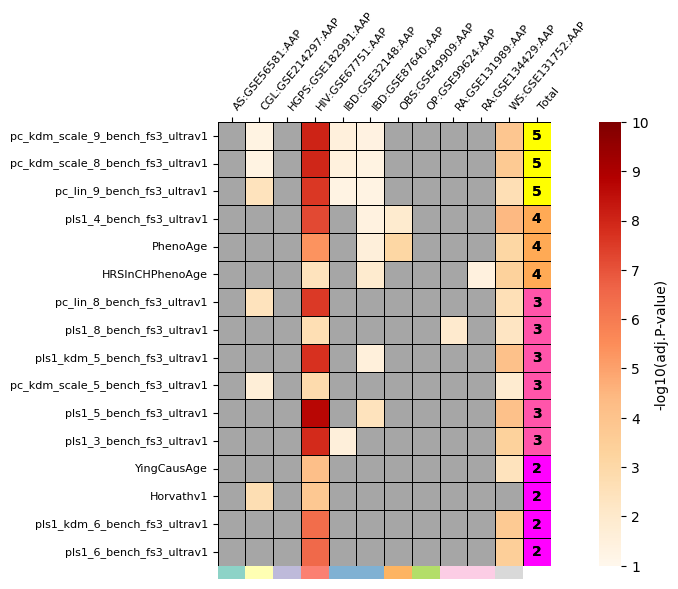

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the main heatmap
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
ax = sns.heatmap(data, square=True, cmap='OrRd',
                 cbar_kws={'label': '-log10(adj.P-value)'},
                 vmin=1, vmax=10,
                 linecolor='k', 
                 linewidth=0.5, 
                 ax=axes, 
                 cbar=True
                 )

data2 = data.copy()
data2.iloc[:, :-1] = float('nan')
sns.heatmap(data2, annot=True, cmap="spring", cbar=False, ax=axes,
            linecolor='k', 
            linewidth=0.5, )

# Add annotations to the last column of the heatmap
for i in range(len(data.index)):
    ax.text(len(data.columns) - 0.5, i + 0.5, str(data.iloc[i, -1]),
            ha='center', va='center', color='k', fontsize=8)

# Change colors of the cells in the last column
for text in ax.texts:
    text.set_color('k')
    text.set_fontweight('bold')
    text.set_fontsize(10)

# Customize x-axis ticks
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position('top')
ax.yaxis.set_tick_params(colors='k')
ax.xaxis.set_tick_params(rotation=50, colors='k')
ax.set_xticklabels(ax.get_xticklabels(), ha='left', fontsize=8, color='k')
ax.set_yticklabels(ax.get_yticklabels(), ha='right', fontsize=8, color='k')



for i, cond in enumerate(data.columns[:-1]):
    cond = cond.split(":")[0]
    color = group_colors[cond]
    ax.add_patch(plt.Rectangle(xy=(i, -0.03), height=0.03, width=1, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))

axes.collections[0].cmap.set_bad('0.65')
plt.tight_layout()
plt.show()